In [1]:
# 가우스 잡음 추가  함수
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

#가우스 노이즈
# noisy_pixel = original_pixel +N(u=0, e = scale)
# 평균을 0으로 만듦: 픽셀을 전체적으로 밝히거나 어둡게 하지 않음
# 표준편차: sacler -> 값이 클수록 노이즈가 강해짐
# 0.8 -> 노이즈의 양  많고.. 숫자 일부를 흐릿

In [ ]:
import numpy as np
gaussian_data_X = np.random.normal(
        loc =0, scale =0.8, size=(1,28,28)
    ) 
gaussian_data_X.shape
np.clip(gaussian_data_X,0,1)
# np.clip(gaussian_data_X,0.1)
#오류의 이유 a_max가 필요하다 ,이지 .을 사용하는 거는 아님


array([[[0.        , 0.        , 0.0305435 , 0.        , 0.        ,
         0.6676615 , 0.        , 0.        , 0.84042013, 0.77994277,
         0.4083756 , 0.13666231, 0.        , 0.31951874, 0.        ,
         0.16082849, 0.        , 0.13052608, 0.31890214, 0.20509157,
         0.        , 1.        , 0.        , 0.        , 0.        ,
         1.        , 0.42385755, 0.        ],
        [0.        , 1.        , 0.14707788, 0.4176176 , 0.        ,
         0.86150632, 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.26319405,
         0.        , 0.92226462, 0.20723772, 1.        , 0.        ,
         0.82229336, 1.        , 0.        , 0.        , 0.4116074 ,
         0.        , 0.06912519, 0.96645385],
        [0.74975139, 0.        , 0.        , 0.        , 0.        ,
         0.19508304, 0.43521989, 0.38223297, 0.52319323, 0.08165543,
         0.42981172, 0.24957665, 0.79407172, 0.        , 0.87913035,
         0.

In [3]:
def gaussian_noise(X, scale=0.8):
    gaussian_data_X =X + np.random.normal(
        loc =0, scale =scale, size=X.shape 
    ) 
    gaussian_data_X = np.clip(gaussian_data_X,0,1)#이미지픽셀의 값을 0과 1사이로 정규화
    gaussian_data_X = torch.tensor(gaussian_data_X,dtype= torch.float32)
    return gaussian_data_X


In [4]:
#학습데이터 정의
training_data = MNIST(root='./', train=True,download=True,transform=ToTensor())
test_data = MNIST(root='./', train=False,download=True,transform=ToTensor())

C:\Users\Playdata2\AppData\Local\Temp\ipykernel_1644\2868163305.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_X =X + np.random.normal(
C:\Users\Playdata2\AppData\Local\Temp\ipykernel_1644\2868163305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_X = torch.tensor(gaussian_data_X,dtype= torch.float32)


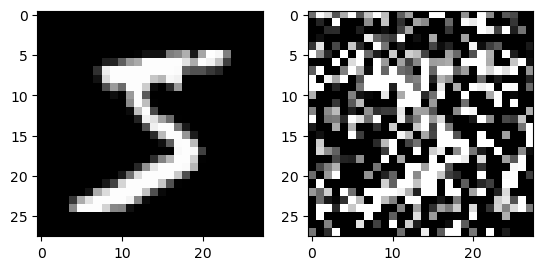

In [26]:
img, label = next(iter(training_data))
gaussian = gaussian_noise(img)
img = img.permute(1,2,0)
gaussian = gaussian.permute(1,2,0)

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gaussian, cmap='gray')

In [27]:
for data, label in training_data:
    noisy = gaussian_noise(data)
    print(type(noisy), noisy.size())
    break

<class 'torch.Tensor'> torch.Size([1, 28, 28])


C:\Users\Playdata2\AppData\Local\Temp\ipykernel_1644\2868163305.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_X =X + np.random.normal(
C:\Users\Playdata2\AppData\Local\Temp\ipykernel_1644\2868163305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_X = torch.tensor(gaussian_data_X,dtype= torch.float32)


In [ ]:
#학습용 데이터셋
from torch.utils.data.dataset import Dataset
class Denoise(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./', train=True,download=True,transform=ToTensor())
        self.data = []
        #잡음 입히기
        for data, label in self.mnist:
            noisy = gaussian_noise(data) #0~1사이로 맞춤
            self.data.append(noisy.unsqueeze((0))) #(1,1,28,28)
        # for i in range(self.mnist.data.size()[0]):
        #     gaussian_noise(self.mnist.data[i])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = self.data[index]
        label = self.mnist.dat[index] / 255 #원본이미지로 0~1 표준화 정규화
        return data, label

In [32]:
# 합성곱 기본 블럭
import torch.nn as nn
#conv-relu-conv-relu
class BasicBlock(nn.Module):
    def __init__(self,in_channel, out_channel,hidden_channel):
        super(BasicBlock,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU()
        )
    def forward(self,X):
        return self.model(X)

In [33]:
sample_data= torch.randn(1,1,28,28)
sample_model = BasicBlock(1,20,10)
sample_model(sample_data).size()

torch.Size([1, 20, 28, 28])

In [38]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)
        self.pool = nn.AvgPool2d(2)
    def forward(self,X):
        X = self.pool(self.conv1(X)) #(1,16,14,14)
        out = self.pool(self.conv2(X)) # 1, 8,7,7
        return out

In [ ]:
sample_data = torch.randn(1,1,28,28)
temp_encoder = Encoder()
result_encoder = temp_encoder(sample_data)

In [36]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16,1,kernel_size=3, padding=1)
        #업셈플링 총
        self.upsampling1 = nn.ConvTranspose2d(8,8,kernel_size=2, stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16,kernel_size=2, stride=2)
    def forward(self,X):
        X = self.upsampling1(self.conv1(X))
        X = self.upsampling2(self.conv2(X))
        out = self.conv3(X)
        return out



In [43]:
d = Decoder()
d(result_encoder).size()

torch.Size([1, 1, 28, 28])

In [44]:
#CAE 오토인코더
# 인코더와 디코더를 연결: 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE,self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self,X):
        X= self.enc(X)
        X= self.dec(X)
        return X


In [49]:
#모델 학습
from tqdm import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else 'cpu'
train_dataset = Denoise()
train_loader = DataLoader(train_dataset, batch_size=32)
model = CAE().to(device)
optim = Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss()
loop = tqdm(train_loader)
for data, label in loop:
    data,label = data.to(device), label.to(device)
    pred = model(data)
    loss = criterion(pred,label)
    loss.backward()
    optim.step()

    loop.set_postfix({'loss': f'{loss.item():.4f}'})

C:\Users\Playdata2\AppData\Local\Temp\ipykernel_1644\2868163305.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_X =X + np.random.normal(
C:\Users\Playdata2\AppData\Local\Temp\ipykernel_1644\2868163305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_X = torch.tensor(gaussian_data_X,dtype= torch.float32)
  0%|          | 0/1875 [00:00<?, ?it/s]


AttributeError: 'MNIST' object has no attribute 'dat'